# <center>Homework 2</center>
### <center>_Tanner S Eastmond_</center>

## Housing Prices

Housing is a very important concern for both companies and families in the United States. In fact, according to the Bureau of Labor Statistics, on average families spend about a quarter of their income on housing. As such, being able to predict the price of a house based on the features it has to offer is quite important.

The data we will use were compiled by Dean De Cock for many different aspects of homes in Ames, Iowa and were downloaded from [Kaggle](https://www.kaggle.com) for the [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition. These data include a 'training' set, which has everything we need, and a 'test' set, which does not include the sale price since it will be used to judge the competition. Let's dive in to the data and see if we can get a feel for what we are dealing with!

In [1]:
# Import the packages we need.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.linear_model import SGDRegressor, LogisticRegression, ElasticNetCV, LassoCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

%matplotlib inline

## Data Description and Cleaning

In [2]:
# Read in the data and get a first look.
df = pd.read_csv('train.csv')
print(df.columns)
df.head()

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Okay! So we have a lot to sift through since there are 79 different variables (outside of the id and sale price), but first I think we ought to try to understand what is going on with sale price.

In [3]:
# Describe the sale price.
df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

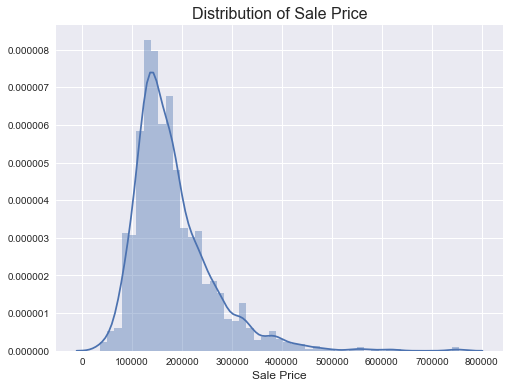

In [4]:
# Plot the distribution of sale price.
f, ax = plt.subplots(figsize=(8, 6))

plt.xlabel('Sale Price', fontsize=12)
plt.title('Distribution of Sale Price', fontsize=16)

sns.distplot(df.SalePrice, axlabel=False)

In [5]:
# Check missing values.
df.SalePrice.isnull().value_counts()

False    1460
Name: SalePrice, dtype: int64

Well that is largely good news for us! We have reasonable values for the maximum and minimum of sale price and no missing values. The distribution is right-skewed, so we will likely want to deal with that before this is all said and done.

Before we continue, lets think about the relationship of our other variables to sale price.

### _Categorical Variables_

Let's check out the categorical variables and get a feel for the distribution of sale price in each category.

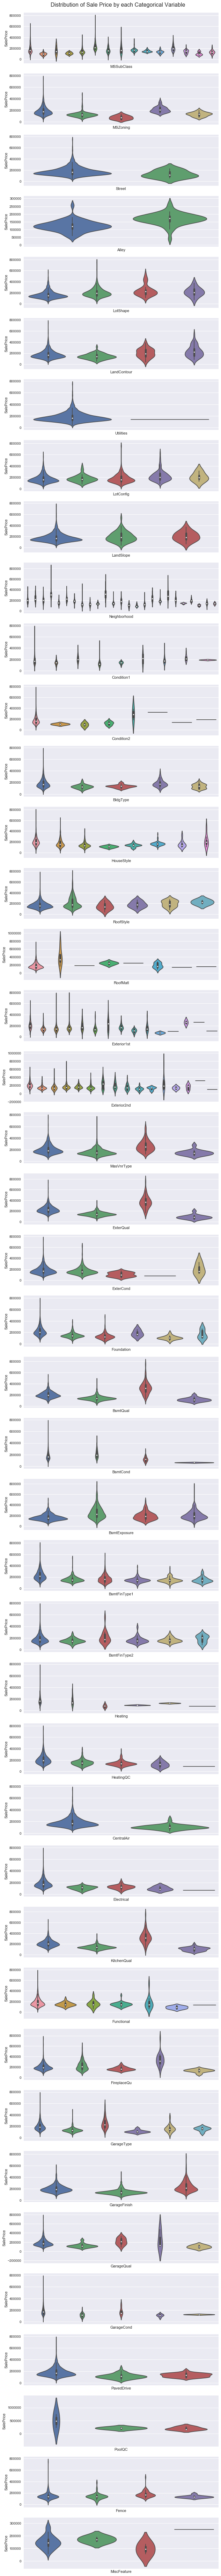

In [6]:
# Plot the distribution of sale price with our categorical variables.
# Define which variables to include and count how many we use.
variables = ('MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
             'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
             'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
             'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
             'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
             'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature')
loc = len(variables)

# Initialize the plot.
fig, ax = plt.subplots(loc,1,figsize=(10,loc*3.2))

# Title the plot.
fig.suptitle('Distribution of Sale Price by each Categorical Variable', fontsize=16, y=.883)

# Define each of the violin plots.
for num, name in enumerate(variables):
    sns.violinplot(x=name, y='SalePrice', data=df, ax=ax[num], axlabel=False)

# Remove the x ticks
for x in ax:
    x.set_xticks([])

This definitely is a ton of information, but we did learn a few important things. First, utilities will not be helpful for us because only one house in the training set did not have full utilities. Second, the distributions for sale price appear to be relatively similar for lot configuration and land shape, but otherwise seem to differ to varying degrees based on the category. So other than eliminating utilities, this suggests that each of our categories could privide useful information for our model.

### _Numeric Variables_

Now we need to examine the numeric variables in our data.

In [7]:
# Make an array of columns.
keep = df.columns

# Delete the categorical and other unrelated variables.
for x in variables + ('Id', 'SalePrice', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'):
    # Find the index of the element.
    index = np.argwhere(keep==x)
    
    # Delete the element.
    keep = np.delete(keep, index)

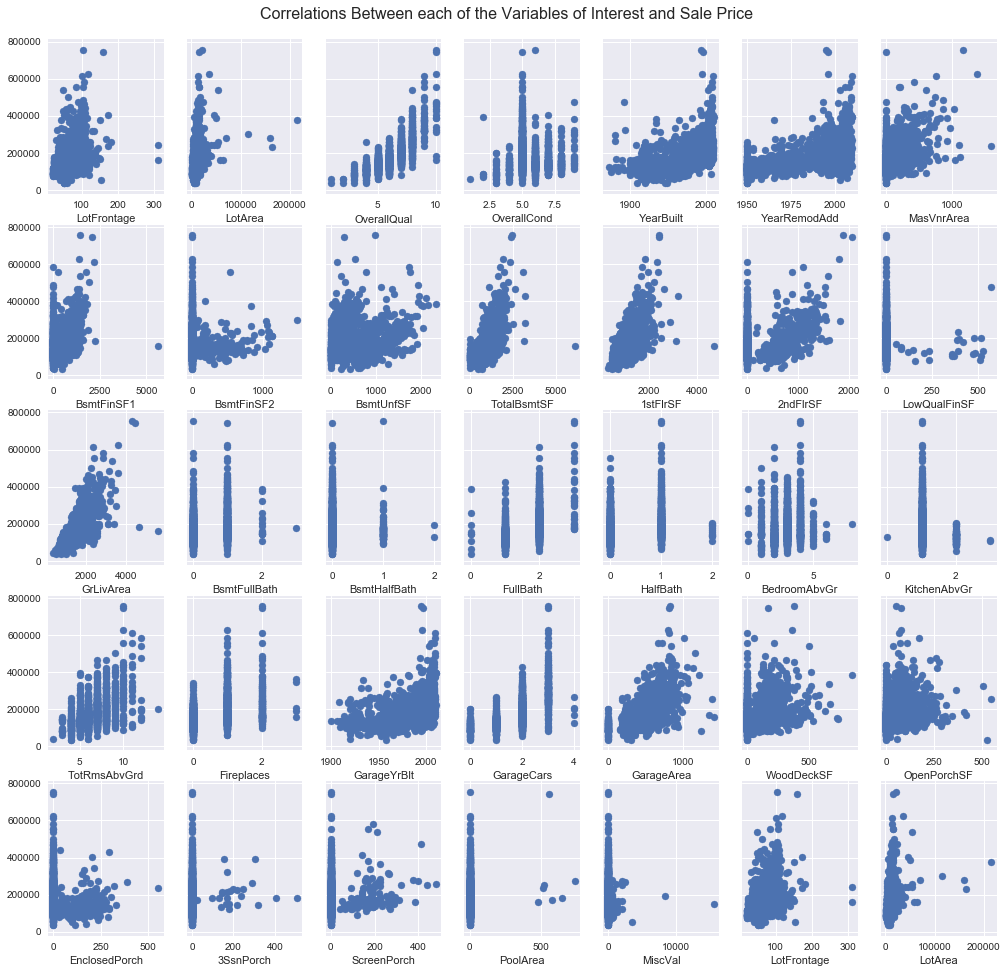

In [8]:
# Make a grid of scatter plots.
# Initialize the plot.
fig, axes = plt.subplots(5, 7, figsize=(17,15), sharey='all')

# Title the plot.
fig.suptitle('Correlations Between each of the Variables of Interest and Sale Price', fontsize=16, y=.91)

# Make sure there is enough room at the bottom to read the labels.
fig.subplots_adjust(bottom=0.05)

# We are short two plots, so we will tag on the first two again for aesthetics.
keep = np.append(keep,keep[0:2])

# Assign the scatter plots.
for num, ax in enumerate(axes.flat):
    ax.scatter(y=df['SalePrice'], x=df[keep[num]])
    ax.set_xlabel(keep[num])

We have largely positive correlations, though there are few enough houses with pools, porches, and miscellaneous things for me to think it would be better to include a binary for having a pool or a porch rather than the size of said variables. We will check a few things, like outliers and functional form below.

First of all, there appear to be a few outliers with lot frontage and our square footage variables, so we will check that out with a few box plots.

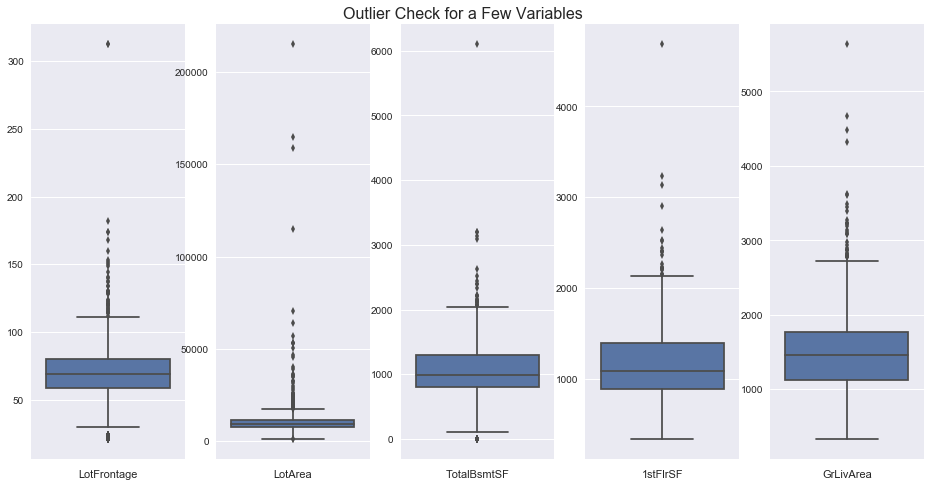

In [9]:
# Make a few box plots.
# Initialize the plot.
fig, axes = plt.subplots(1, 5, figsize=(16,8))

# Title the plot.
fig.suptitle('Outlier Check for a Few Variables', fontsize=16, y=.91)

# Make a list of variables.
varlist = ['LotFrontage', 'LotArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']

# Assign the scatter plots.
for num, ax in enumerate(axes.flat):
    sns.boxplot(x=df[varlist[num]], orient='v', ax=ax)
    ax.set_xlabel(varlist[num])
    ax.set_ylabel('')

As the outliers are likely not very representative of the data as a whole, I will drop the outliers in each category.

In [10]:
# Drop outliers found above.
df = df[(df.LotFrontage < 200) & (df.LotArea < 100000) & (df.TotalBsmtSF < 3000) & (df['1stFlrSF'] < 3000) & (df.GrLivArea < 4000)]

We are not going to be super robust about this, but we have a couple of functional form problems as well, so we will include square terms for those variables.

In [11]:
# Square a few variables.
df['OverallQual2'] = df.OverallQual**2
df['GarageCars2'] = df.GarageCars**2

We also likely want a variable for total square footage.

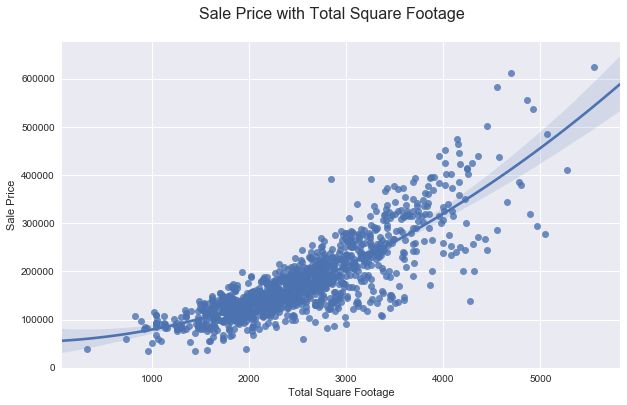

In [12]:
# Make a total square footage variable.
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

# Scatter to see what the data look like.
# Initialize the plot.
fig, ax = plt.subplots(figsize=(10, 6))

# Set the title.
fig.suptitle('Sale Price with Total Square Footage', fontsize=16, y=.96)

# Set the plot.
sns.regplot(y=df.SalePrice, x=df.TotalSF, order=2, ax=ax)

# Fix the axis labels.
ax.set_ylabel('Sale Price')
ax.set_xlabel('Total Square Footage')

That looks much nicer with the quadratic fit, so we will make that variable to include.

In [13]:
df['TotalSF2'] = df.TotalSF**2

### _Missing Data and Miscellaneous Cleaning_

The last thing we will think about is missing data. We need to first see where we have missing data issues.

In [14]:
# Make a list of the number of missing values per column.
miss = list(df.isnull().sum())

# Print out the columns with missing values and their names.
for x, y in enumerate(df.columns):
    if miss[x] > 0:
        print(y, miss[x])

Alley 1107
MasVnrType 6
MasVnrArea 6
BsmtQual 31
BsmtCond 31
BsmtExposure 32
BsmtFinType1 31
BsmtFinType2 31
Electrical 1
FireplaceQu 600
GarageType 74
GarageYrBlt 74
GarageFinish 74
GarageQual 74
GarageCond 74
PoolQC 1189
Fence 966
MiscFeature 1154


Lot frontage appears to have a strong positive correlation with sale price, so we will impute those missing values using the mean. We will throw out alley and fence, as they are largely missing so will not contribute much to the model. We are already dealing with pool and miscellaneous features, and we will throw fireplace in with these as a binary variable.

For the missing categorical data, we will make a 'None' category in accordance with the documentation.

In [15]:
# Delete fence, alley, and utilities.
del df['Fence']
del df['Alley']
del df['Utilities']

# Mean imputation for lot frontage.
df.loc[df.LotFrontage.isnull(), 'LotFrontage'] = df.LotFrontage.mean()

# None for categorical variables.
for y in ('MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                       'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual',
                       'GarageCond'):
    df[y] = df[y].fillna('None')
    
# Garage year built is harder, we will fill missing with the house year built.
df.loc[df.GarageYrBlt.isnull(), 'GarageYrBlt'] = df.YearBuilt

# Fill area with 0.
df['MasVnrArea'] = df['MasVnrArea'].fillna(0.0)

Last thing we need is to make binary variables for each of our categories then to keep the final set of variables.

In [16]:
# Get all of the included categories first.
variables2 = ('MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 
             'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
             'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
             'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
             'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
             'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'PavedDrive',)
df['MSSubClass'] = df['MSSubClass'].astype(str)
df1 = pd.get_dummies(df[np.array(variables2)])

# Join with the original data.
full = df.join(df1)

# Make binaries for pool, porch, miscellaneous, and fire place.
full['HasPool'] = full.PoolQC.notnull().astype(int)
full['HasPorch'] = ((full.OpenPorchSF > 0) | (full.EnclosedPorch > 0) | (full['3SsnPorch'] > 0) | (full.ScreenPorch > 0)).astype(int)
full['HasMisc'] = full.MiscFeature.notnull().astype(int)
full['HasFire'] = full.FireplaceQu.notnull().astype(int)

# Drop all of the unnecessary variables from our model.
for x in variables2 + ('OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
                       'MiscVal', 'FireplaceQu', 'PoolQC', 'MiscFeature', 'SaleType', 'SaleCondition',
                       'MoSold', 'YrSold'):
    del full[x]
    
# Reset the index.
full = full.set_index('Id')

## Model

We have definitely learned a few things. We will certainly not include utilities in the model, and we should also include a binary for having a pool, porch, or miscellaneous items. Otherwise, the features appear to be reasonably correlated with sale price, so we will parse out what is important in the model. 

At this point let's make a train/test split that we keep for each of the models. This will allow us to evaluate the quality of the model on our training set before we run it on the actual test data and submit to Kaggle. We also want to standardize all of the variables in our model.

In [17]:
# Mark the target variable and get the full data.
target = full.SalePrice
train = full.drop('SalePrice', axis=1)

# Standardize the data.
scaler = StandardScaler()
scaler.fit(train)
scaled = scaler.transform(train)

# Make a train/test split.
X_train, X_test, y_train, y_test = train_test_split(scaled, target, test_size=0.33, random_state=42)

### _Kitchen Sink Linear Regression Model_

Now that we have chosen a reasonable set of variables, let's first run a naive model where we just throw in everything from our data and see what we get! We will, again, naively, use an arbitrary learning rate of 0.001 and convergence criteria of 0.001

In [18]:
# Fit the model.
linear_regression_model = SGDRegressor(tol=.001, eta0=.001)
linear_regression_model.fit(X_train, y_train)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

# Print out the resultant RMSE.
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train, train_predictions))))
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, test_predictions))))

Train RMSE: 18352.191864126078
Test RMSE: 34738.37106319781


We don't necessarily have a benchmark for what is good here, though the model is certainly overfit, so let's look at a few other models and compare.

### _Kitchen Sink Linear Regression Model with Cross-Validated Parameters_

We will run the same model now, but first we will look to select an 'optimal' learning rate and convergence criteria using cross validation.

In [19]:
# Specify a few different parameters to try.
param_dist = {"tol" : [.0001, .0003, .001, .003], "eta0" : [.001, .003, .01, .03, .1, .3, 1, 3]}

# Set the parameters and choose the ideal parameters.
linear_regression_model = SGDRegressor()
n_iter_search = 10
random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

# Predict the values.
train_predictions = random_search.predict(X_train)
test_predictions = random_search.predict(X_test)

# Print the results.
print("Best Parameters: {}".format(random_search.best_params_))
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train, train_predictions))))
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, test_predictions))))

Best Parameters: {'tol': 0.0001, 'eta0': 0.003}
Train RMSE: 18438.023190576274
Test RMSE: 34924.53974186957


Great! So we improved our RMSE a little bit using a learning rate of 0.001 and a convergence criteria of 0.003. Overfitting is again almost certainly a problem in this model, though, because our training set RMSE is so much smaller than our testing set RMSE. Because of this we likely should not trust the predictions of this model much, so let's move on to some more sophisticated methods of feature selection.

### _Selective Linear Regression_

To this point we have thrown everything from our data at this problem, but since it is likely we are overfitting, perhaps we should be more selective about our features. First we will use elastic net to see if we improve the model. 

In [20]:
# Set the parameters to test.
clf = ElasticNetCV(l1_ratio=[.01, .1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10], max_iter=20000)

# Fit the model.
clf.fit(X_train, y_train)

# Get the predictions from the model.
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

# Print the results.
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train, train_predictions))))
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, test_predictions))))
print("Train log RMSE: {}".format(np.sqrt(mean_squared_error(np.log(y_train), np.log(train_predictions)))))
print("Test log RMSE: {}".format(np.sqrt(mean_squared_error(np.log(y_test), np.log(test_predictions)))))

Train RMSE: 19332.54006016282
Test RMSE: 22142.88209150226
Train log RMSE: 0.10303016307109007
Test log RMSE: 0.13228763925210826


This looks much better on the overfitting front! I prefer using lasso since it pushes the coefficients all of the way to zero, so now let's use it to select only the features that really matter. We will use cross-validation to select how heavily to weight the penalty.

In [21]:
# Fit the lasso regression with cross validated alpha.
lasso = LassoCV(alphas=[.1 ,1 ,10, 100, 250, 500, 750, 1000], max_iter=20000)
lasso.fit(X_train, y_train)

# Get the new, limited features from the data.
model = SelectFromModel(lasso, prefit=True)
X_train_new = model.transform(X_train)
X_test_new = model.transform(X_test)

# Get the predictions from the model.
train_predictions = lasso.predict(X_train)
test_predictions = lasso.predict(X_test)

# Print the results.
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train, train_predictions))))
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, test_predictions))))
print("Train log RMSE: {}".format(np.sqrt(mean_squared_error(np.log(y_train), np.log(train_predictions)))))
print("Test log RMSE: {}".format(np.sqrt(mean_squared_error(np.log(y_test), np.log(test_predictions)))))

Train RMSE: 18504.560867503147
Test RMSE: 21944.08975048764
Train log RMSE: 0.10386325460250335
Test log RMSE: 0.13297367991613318


Even a little better than before, and we significantly reduced the features we were including in the model. Below is a list of the included coefficients.

In [46]:
# Print the coefficients retained after lasso.
for x, y in enumerate(train.columns):
    if abs(lasso.coef_[x]) != 0.0:
        print(y, lasso.coef_[x])

LotFrontage 29.7817028173
LotArea 1.36141381605
OverallQual -10480.8426401
OverallCond 6311.0283156
YearBuilt 351.029188001
YearRemodAdd 115.526364542
MasVnrArea 13.0196084298
BsmtFinSF1 24.1906906569
BsmtFinSF2 12.2705512885
BsmtUnfSF 6.96355937743
TotalBsmtSF 8.38346035738
1stFlrSF 31.2314328453
2ndFlrSF 33.5696574579
LowQualFinSF 8.26080883086
GrLivArea 7.30593669692
BsmtFullBath 741.794025309
BsmtHalfBath -1692.39230032
FullBath 3752.79914553
HalfBath 5376.62515454
BedroomAbvGr -2988.60925272
KitchenAbvGr -7737.93421431
TotRmsAbvGrd 1269.37580399
Fireplaces 2340.21911838
GarageYrBlt 66.6926274224
GarageCars -1073.86260316
GarageArea 8.53118580502
WoodDeckSF 4.08735347658
OverallQual2 1634.22371169
GarageCars2 1839.84919012
TotalSF -41.3908228961
TotalSF2 0.00879924717929
MSSubClass_160 -6037.74529687
MSZoning_C (all) -12927.1039537
MSZoning_FV 8637.90585958
MSZoning_RL 1220.62316325
MSZoning_RM -1397.25665803
LotShape_IR1 -700.611304829
LotShape_IR2 1496.46893023
LandContour_Low -9

Notice that our square footage, neighborhood, garage, and basement features were largely retained, along with other things of course. Based on our results, the model works reasonably well, but still has quite high Mean Square Error. I think this model would be useful in approximating the rough class of housing price, but I do not think it would be useful in predicting accurate housing prices.

### _Classification Supplement_

Now we are going to try to get a little more fancy with our new, selected features. We will first classify the observations into below or above the median, then we will run a linear regression on each of the individuals pieces, since it is likely that out features affect housing prices differentially above and below the median.

In [22]:
# Generate the buckets.
y_train_new = y_train > y_train.median()
y_test_new = y_test > y_test.median()

In [23]:
# Fit the logistic regression.
log = LogisticRegression()
log.fit(X_train_new, y_train_new)

# Get the predictions.
train_predictions = log.predict(X_train_new)
test_predictions = log.predict(X_test_new)

# Print out the accuracy.
print("Train acc: {}".format(accuracy_score(y_train_new, train_predictions)))
print("Test acc: {}".format(accuracy_score(y_test_new, test_predictions)))

Train acc: 0.9749687108886108
Test acc: 0.916243654822335


We have the predictions we need with reasonable accuracy, so let's split the training and test sets into two different pools to train a linear regression.

In [24]:
# Assign the dataframes.
# Get the training data with the predictions and y values.
split1_train = pd.DataFrame(X_train_new)
split1_train['pred'] = train_predictions.astype(int)
test = pd.DataFrame(y_train)
test = test.reset_index()
split1_train['yval'] = test['SalePrice']
split2_train = split1_train.loc[split1_train['pred'] == 1]
split1_train = split1_train.loc[split1_train['pred'] == 0]

# Get the test data with the predictions and y values.
split1_test = pd.DataFrame(X_test_new)
split1_test['pred'] = test_predictions.astype(int)
test = pd.DataFrame(y_test)
test = test.reset_index()
split1_test['yval'] = test['SalePrice']
split2_test = split1_test.loc[split1_test['pred'] == 1]
split1_test = split1_test.loc[split1_test['pred'] == 0]

# Assign the x and y values for training and test
split1_train_target = split1_train.yval
split1_train = split1_train.drop(['pred', 'yval'], axis=1)

split2_train_target = split2_train.yval
split2_train = split2_train.drop(['pred', 'yval'], axis=1)

split1_test_target = split1_test.yval
split1_test = split1_test.drop(['pred', 'yval'], axis=1)

split2_test_target = split2_test.yval
split2_test = split2_test.drop(['pred', 'yval'], axis=1)

Let's run the linear regression model now!

In [25]:
# Specify a few different parameters to try.
param_dist = {"tol" : [.0001, .0003, .001, .003], "eta0" : [.001, .003, .01, .03, .1, .3, 1, 3]}

# Set the parameters and choose the ideal parameters.
linear_regression_model = SGDRegressor(max_iter=10000)
n_iter_search = 10
random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
random_search.fit(split1_train, split1_train_target)

# Predict the values.
train_predictions1 = random_search.predict(split1_train)
test_predictions1 = random_search.predict(split1_test)

# Set the parameters and choose the ideal parameters.
linear_regression_model2 = SGDRegressor(max_iter=10000)
random_search2 = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
random_search2.fit(split2_train, split2_train_target)

# Predict the values.
train_predictions2 = random_search.predict(split2_train)
test_predictions2 = random_search.predict(split2_test)

# Print the results.
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(np.append(split1_train_target,split2_train_target), 
                                                         np.append(train_predictions1, train_predictions2)))))
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(np.append(split1_test_target,split2_test_target),
                                                         np.append(test_predictions1, test_predictions2)))))

Train RMSE: 113733.26536307124
Test RMSE: 102348.6783798867


Well, that was definitely worse than our other models, but it was worth a try! Likely we just conglomerated the error from the logistic regression with that from the linear regression.

## Submission

Now we will use the best model to prepare the submission for Kaggle.

In [26]:
# Read in the data.
test = pd.read_csv('test.csv')

We need to clean this data in exactly the same way we cleaned the training data.

In [27]:
# Delete fence, alley, and utilities.
del test['Fence']
del test['Alley']
del test['Utilities']

# Mean imputation for lot frontage.
test.loc[test.LotFrontage.isnull(), 'LotFrontage'] = test.LotFrontage.mean()

# None for categorical variables.
for y in ('MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                       'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual',
                       'GarageCond'):
    test[y] = test[y].fillna('None')
    
# Garage year built is harder, we will fill missing with the house year built.
test.loc[test.GarageYrBlt.isnull(), 'GarageYrBlt'] = test.YearBuilt

# Fill area with 0.
test['MasVnrArea'] = test['MasVnrArea'].fillna(0.0)

# Get all of the included categories first.
variables2 = ('MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 
             'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
             'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
             'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
             'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
             'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'PavedDrive',)
test['MSSubClass'] = test['MSSubClass'].astype(str)
test1 = pd.get_dummies(test[np.array(variables2)])

# Join with the original data.
full1 = test.join(test1)

# Make binaries for pool, porch, miscellaneous, and fire place.
full1['HasPool'] = full1.PoolQC.notnull().astype(int)
full1['HasPorch'] = ((full1.OpenPorchSF > 0) | (full1.EnclosedPorch > 0) | (full1['3SsnPorch'] > 0) | (full1.ScreenPorch > 0)).astype(int)
full1['HasMisc'] = full1.MiscFeature.notnull().astype(int)
full1['HasFire'] = full1.FireplaceQu.notnull().astype(int)

# Drop all of the unnecessary variables from our model.
for x in variables2 + ('OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
                       'MiscVal', 'FireplaceQu', 'PoolQC', 'MiscFeature', 'SaleType', 'SaleCondition',
                       'MoSold', 'YrSold'):
    del full1[x]

There are a few other variables with missing value in this data, so we will deal with those below.

In [28]:
# Make a list of the number of missing values per column.
miss = list(full1.drop('Id',axis=1).isnull().sum())

# Print out the columns with missing values and their names.
for x, y in enumerate(full1.drop('Id',axis=1).columns):
    if miss[x] > 0:
        print(y, miss[x])

BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageCars 1
GarageArea 1


In [29]:
# Replace each variable with the mean.
for x in ('BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea', 'BsmtFinSF1'):
    full1[x] = full1[x].fillna(0.0)

In [30]:
# Make a total square footage variable.
full1['TotalSF'] = full1['TotalBsmtSF'] + full1['1stFlrSF'] + full1['2ndFlrSF']
full1['TotalSF2'] = full1.TotalSF**2

# Square a few variables.
full1['OverallQual2'] = full1.OverallQual**2
full1['GarageCars2'] = full1.GarageCars**2

I have a few variables in the training data not in the test data, I will make the columns here so that the predictions work correctly.

In [31]:
# Get the missing columns.
cols = []
for x in train.columns:
    if x not in full1.columns:
        cols.append(x)
        print(x)

# Generate columns with all zeros.
for x in cols:
    full1[x] = 0   

Condition2_RRNn
HouseStyle_2.5Fin
RoofMatl_Membran
RoofMatl_Roll
Exterior1st_ImStucc
Exterior1st_Stone
Exterior2nd_Other
Heating_OthW
Electrical_Mix
Electrical_None
GarageQual_Ex


In [32]:
# Delete variables not contained in both data sets.
del full1['MSSubClass_150']
del full1['RoofStyle_Shed']
del full1['Functional_Sev']

Now we will make the predictions and save the data.

In [40]:
# Fit the lasso regression with cross validated alpha.
lasso = LassoCV(alphas=[10,100,250,500,750,1000], max_iter=1000000)
lasso.fit(train, target)

# Make the predictions for this data.
final_predictions = lasso.predict(full1.drop('Id', axis=1))

# Make final data.
final = pd.DataFrame()
final['Id'] = full1.Id
final['SalePrice'] = final_predictions

# Write to a csv.
final.to_csv('submission_v2.csv',index=False)